In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 50
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1972-04-02', datetime.date(2022, 4, 2))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


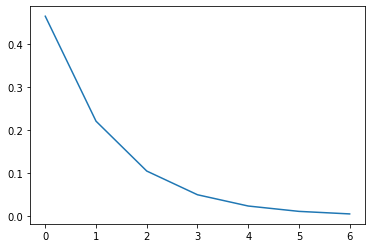

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.005368709120000003

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-03-28  19.316096  7.802058  19.316096  7.802058  19.316096  7.802058   
2022-03-29  20.125615  8.061235  20.125615  8.061235  20.125615  8.061235   
2022-03-30  19.663873  7.890583  19.663873  7.890583  19.663873  7.890583   
2022-03-31  19.265694  7.739855  19.265694  7.739855  19.265694  7.739855   
2022-04-01  19.424377  7.800149  19.424377  7.800149  19.424377  7.800149   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-03-28  19.316096  7.802058  19.316096  7.802058  
2022-03-29  20.125615  8.061235  20.125615  8.061235  
2022-03-30  19.663873  7.890583  19.663873  7.890583  
2022-03-31  19.265694  7.739855  19.265694  7.739855  
2022-04-01  19.424377  7.800149  19.424377  7.800149

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                      Close              \
        ^GSPC       ^IXIC        ^NYA ^W5000       ^GSPC       ^IXIC   
0  107.480003  128.059998  632.520020    NaN  107.480003  128.059998   
1  108.120003  128.779999  636.219971    NaN  108.120003  128.779999   
2  109.000000  130.000000  641.609985    NaN  109.000000  130.000000   
3  109.529999  130.919998  644.260010    NaN  109.529999  130.919998   
4  109.620003  131.800003  645.840027    NaN  109.620003  131.800003   

                            High              ... DayToDayChange  \
         ^NYA ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
0  632.520020    NaN  108.260002  128.059998  ...            NaN   
1  636.219971    NaN  108.620003  128.779999  ...            NaN   
2  641.609985    NaN  109.639999  130.000000  ...            NaN   
3  644.260010    NaN  110.290001  130.919998  ...            NaN   
4  645.840027    NaN  110.150002  131.800003  ...            NaN   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  \
           ^W5000    mine1          mine1          mine1           mine1   
0             NaN      NaN            NaN            NaN             NaN   
1             NaN      NaN            NaN            NaN             NaN   
2             NaN      NaN            NaN            NaN             NaN   
3             NaN      NaN            NaN            NaN             NaN   
4             NaN      NaN            NaN            NaN             NaN   

  LogValue IntradayChange DayToDayChange OvernightChange  
     mine2          mine2          mine2           mine2  
0      NaN            NaN            NaN             NaN  
1      NaN            NaN            NaN             NaN  
2      NaN            NaN            NaN             NaN  
3      NaN            NaN            NaN             NaN  
4      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

12606   2022-03-28
12607   2022-03-29
12608   2022-03-30
12609   2022-03-31
12610   2022-04-01
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                      Close              \
                 ^GSPC       ^IXIC        ^NYA ^W5000       ^GSPC       ^IXIC   
Date                                                                            
1972-04-03  107.480003  128.059998  632.520020    NaN  107.480003  128.059998   
1972-04-04  108.120003  128.779999  636.219971    NaN  108.120003  128.779999   
1972-04-05  109.000000  130.000000  641.609985    NaN  109.000000  130.000000   
1972-04-06  109.529999  130.919998  644.260010    NaN  109.529999  130.919998   
1972-04-07  109.620003  131.800003  645.840027    NaN  109.620003  131.800003   

                                     High              ... DayToDayChange  \
                  ^NYA ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
Date                                                   ...                  
1972-04-03  632.520020    NaN  108.260002  128.059998  ...            NaN   
1972-04-04  636.219971    NaN  108.620003  128.779999  ...            NaN   
1972-04-05  641.609985    NaN  109.639999  130.000000  ...            NaN   
1972-04-06  644.260010    NaN  110.290001  130.919998  ...            NaN   
1972-04-07  645.840027    NaN  110.150002  131.800003  ...            NaN   

           OvernightChange LogValue IntradayChange DayToDayChange  \
                    ^W5000    mine1          mine1          mine1   
Date                                                                
1972-04-03             NaN      NaN            NaN            NaN   
1972-04-04             NaN      NaN            NaN            NaN   
1972-04-05             NaN      NaN            NaN            NaN   
1972-04-06             NaN      NaN            NaN            NaN   
1972-04-07             NaN      NaN            NaN            NaN   

           OvernightChange LogValue IntradayChange DayToDayChange  \
                     mine1    mine2          mine2          mine2   
Date                                                                
1972-04-03             NaN      NaN            NaN            NaN   
1972-04-04             NaN      NaN            NaN            NaN   
1972-04-05             NaN      NaN            NaN            NaN   
1972-04-06             NaN      NaN            NaN            NaN   
1972-04-07             NaN      NaN            NaN            NaN   

           OvernightChange  
                     mine2  
Date                        
1972-04-03             NaN  
1972-04-04             NaN  
1972-04-05             NaN  
1972-04-06             NaN  
1972-04-07             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.2213282



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 40.490424861538415
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 40.490424861538415
Refitting current best...
Current best ew_ma returns: 52.52099974208926
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 52.52103739699549
Invested: 1.0
New best: 52.521042623520025
Invested: 1.0
New best: 52.52121587071066
Invested: 1.0
New best: 52.52124067007908
Invested: 1.0
New best: 52.52126924607615
Invested: 1.0
New best: 52.5213

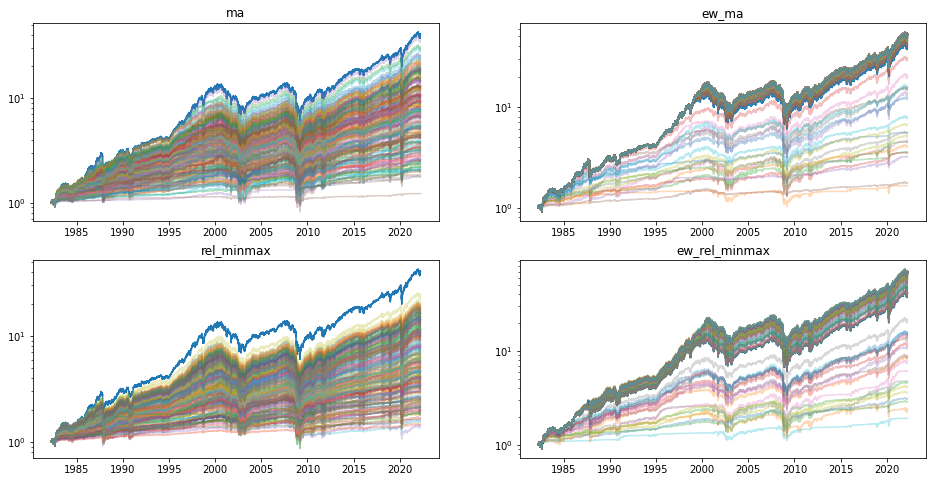

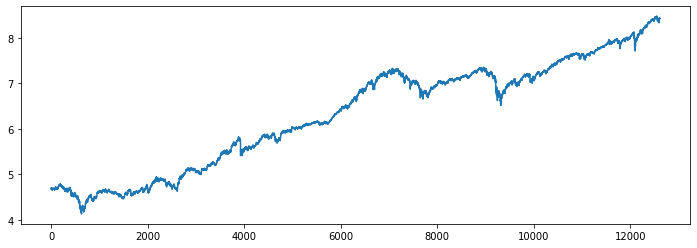

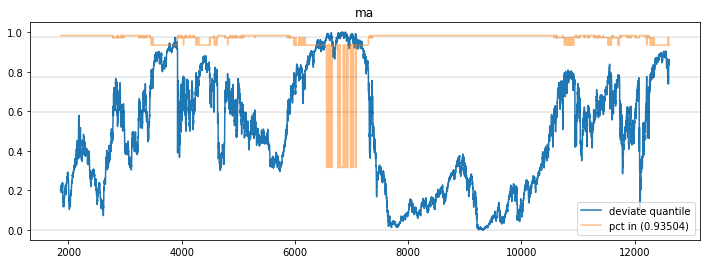

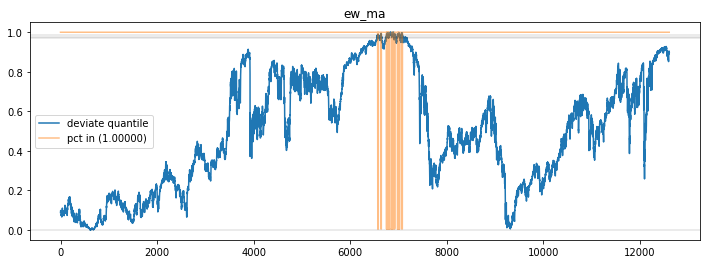

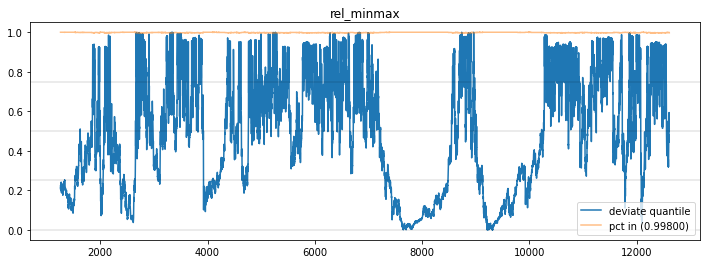

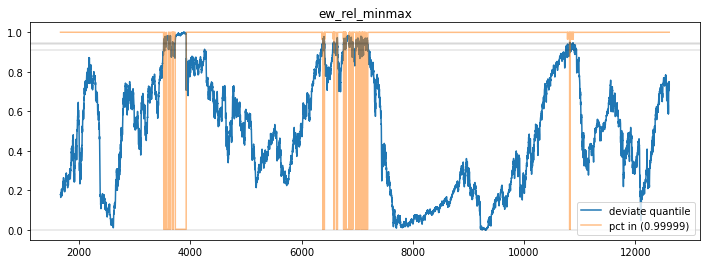

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 81.29916856038777
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 81.29916856038777
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 81.29916856038777
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust

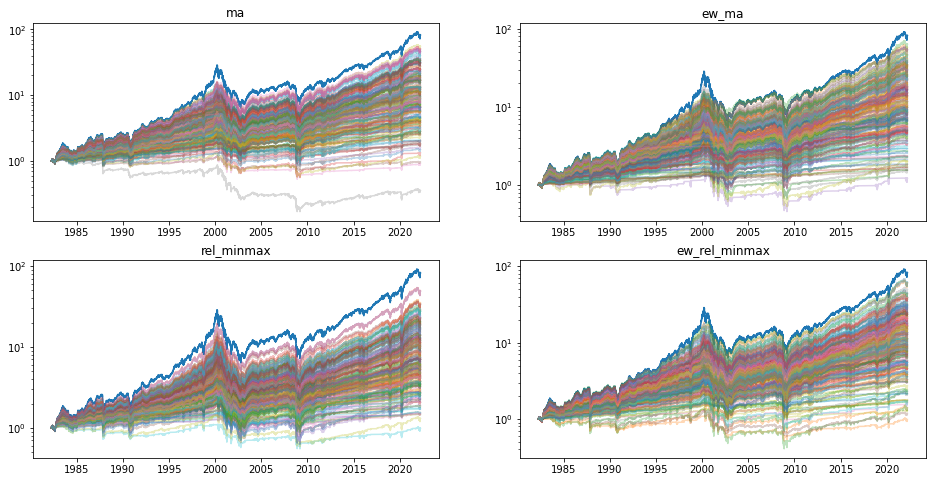

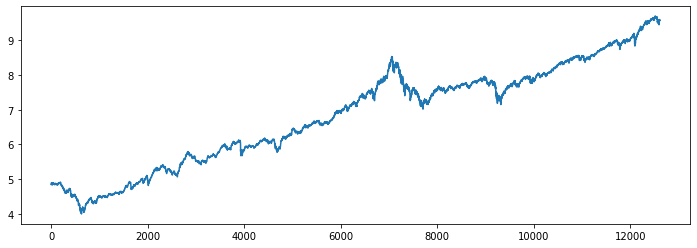

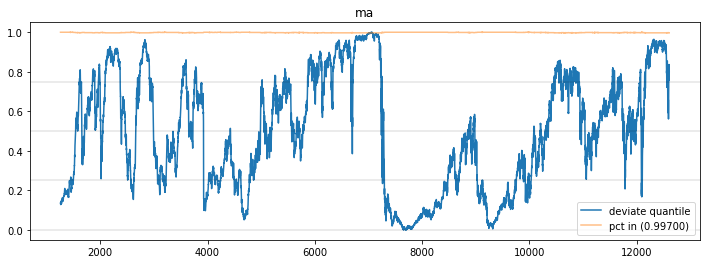

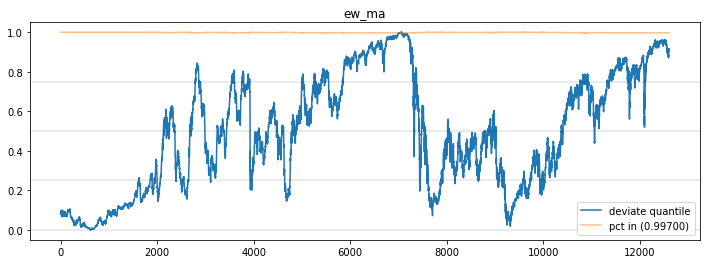

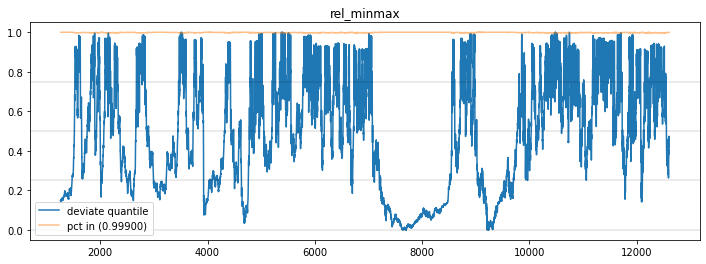

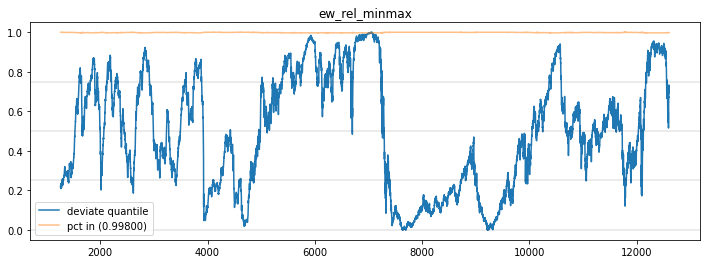

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 24.558213754557055
Refitting current best...
Current best ma returns: 30.94635792547108
Fraction Invested: 0.9986544402476415
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 31.534960608444024
Invested: 0.9986544402476415
New best: 31.636267280218703
Invested: 0.9998575333942457
New best: 31.64014616875985
Invested: 0.9998575333942457
New best: 31.640363593270806
Invested: 0.9998575333942457
New best: 31.640580651415856
Invested: 0.9998575333942457
New best: 31.643246986257154
Invested: 0.9998891474981061
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 24.558213754557055
Refitting

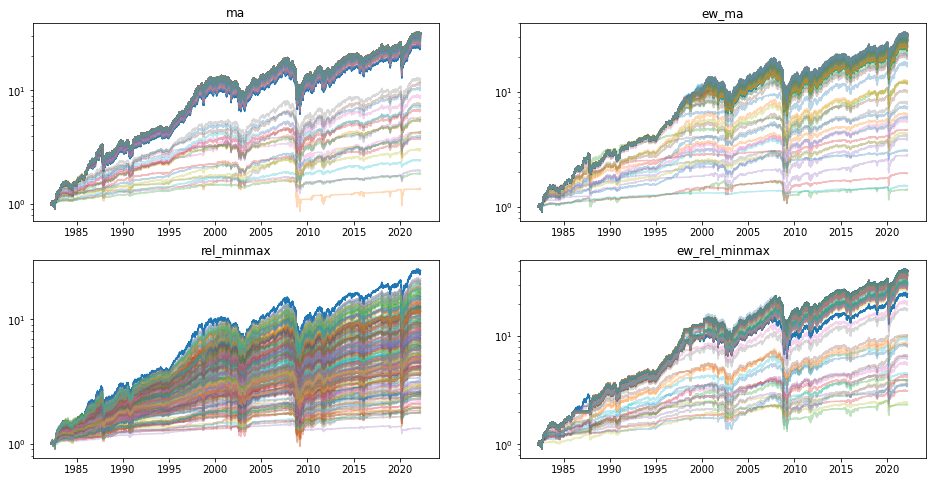

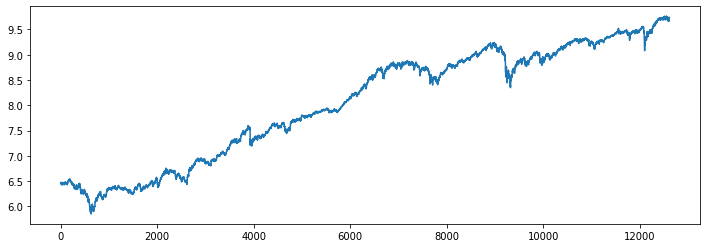

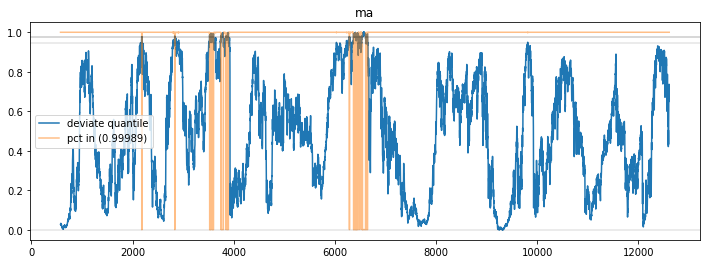

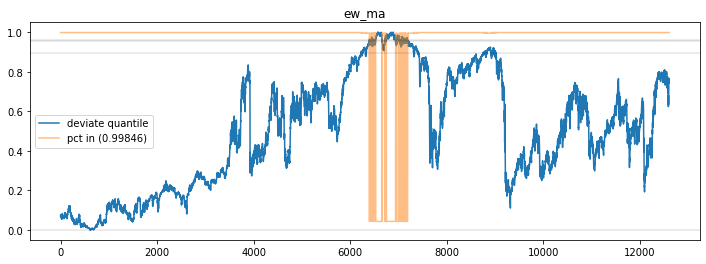

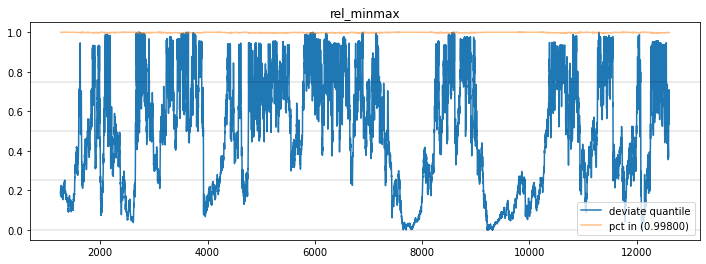

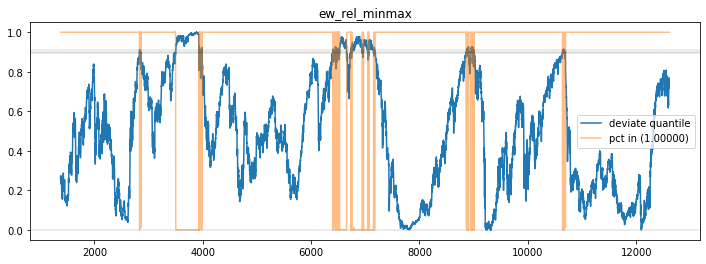

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 8.222578861803155
Refitting current best...
Current best ma returns: 9.631037439140457
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 8.222578861803155
Refitting current best...
Current best ew_ma returns: 13.721899520385572
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 8.222578861803155
Refitting current best...
Current best rel_minmax returns: 8.513984135029819


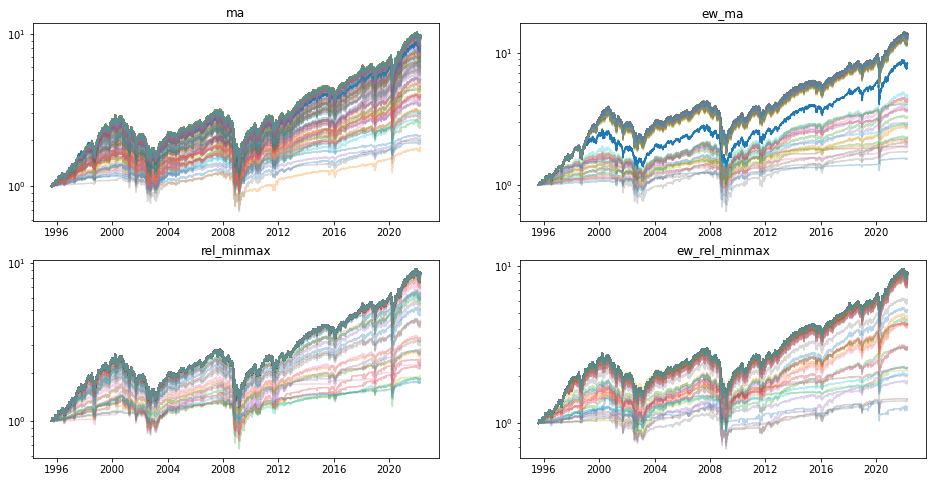

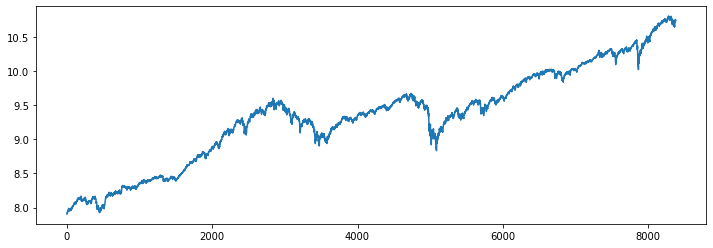

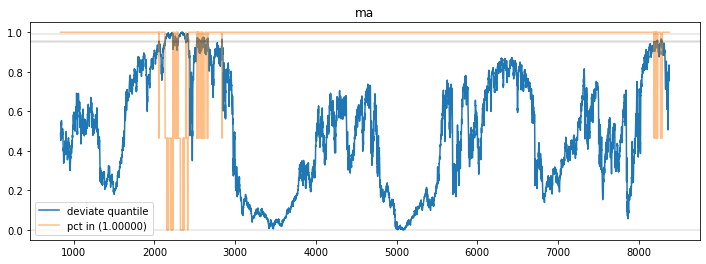

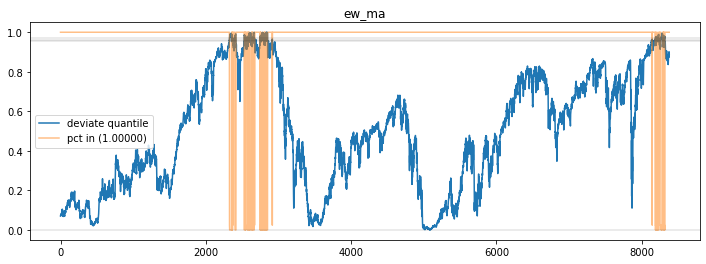

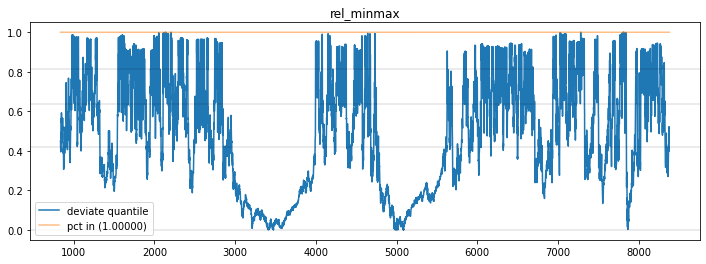

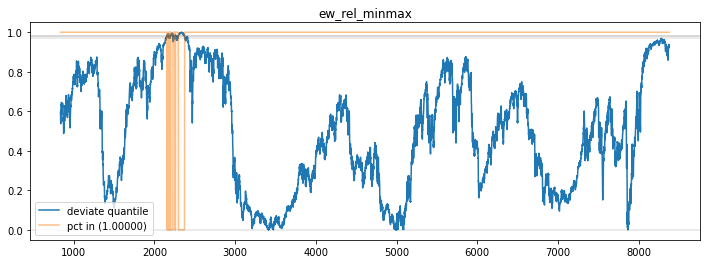

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 14.03912103616735
Refitting current best...
Current best ma returns: 15.83726462974639
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 14.03912103616735
Refitting current best...
Current best ew_ma returns: 16.7797733165832
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 16.779774146975917
Invested: 1.0
New best: 16.779775532476954
Invested: 1.0
New best: 16.7802478658944
Invested: 1.0
Round: 180


Beginning rel_minmax method...
----------------------------------------

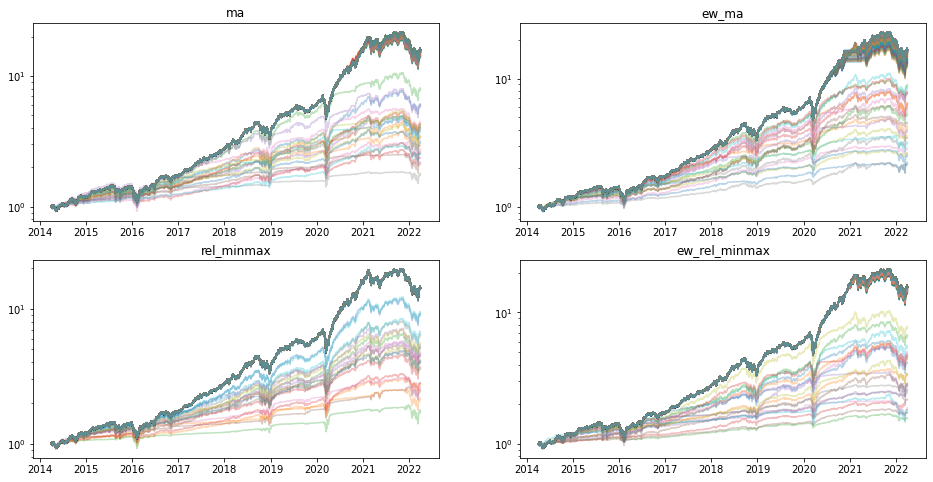

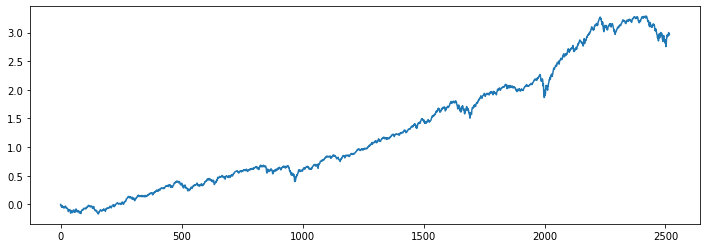

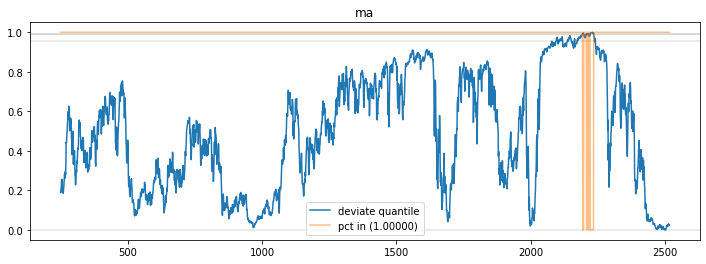

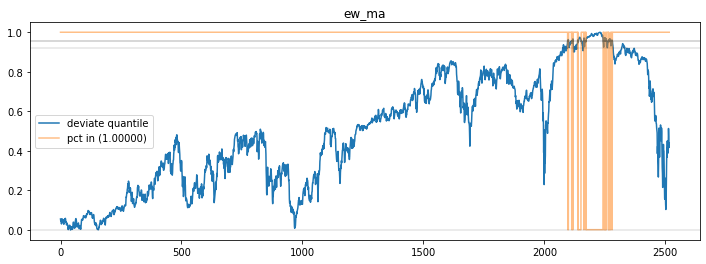

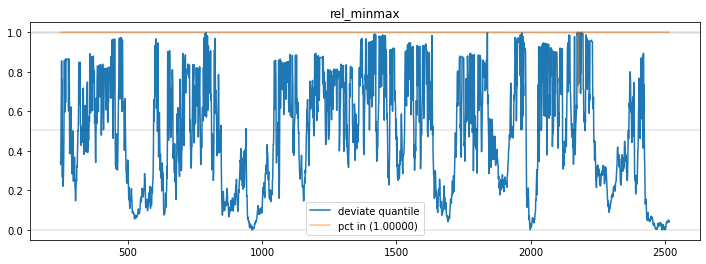

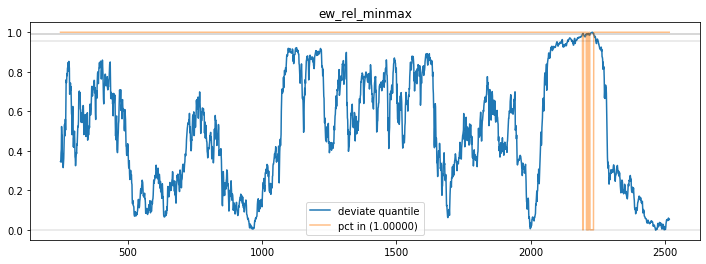

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 5.637332371719867
Refitting current best...
Current best ma returns: 7.491540089048366
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 7.539898339974414
Invested: 1.0
New best: 7.550996407616773
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 5.637332371719867
Refitting current best...
Current best ew_ma returns: 8.546111668746443
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 5.6373323717

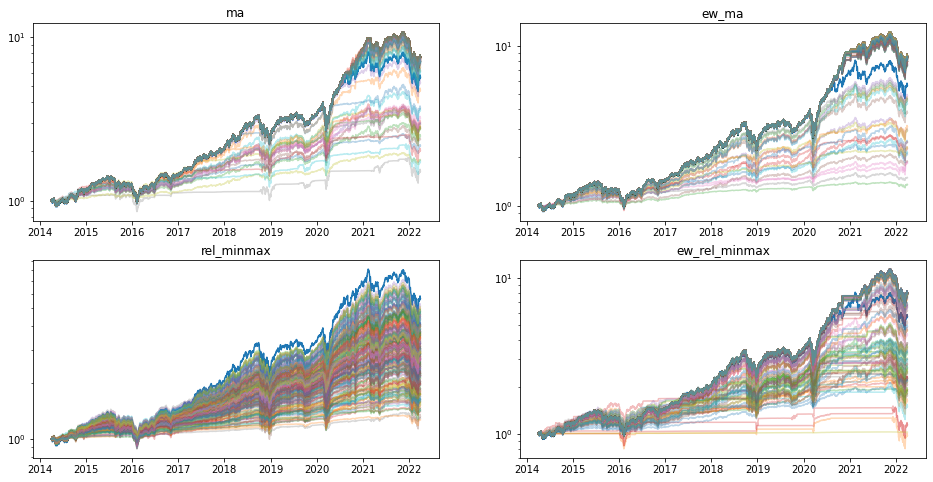

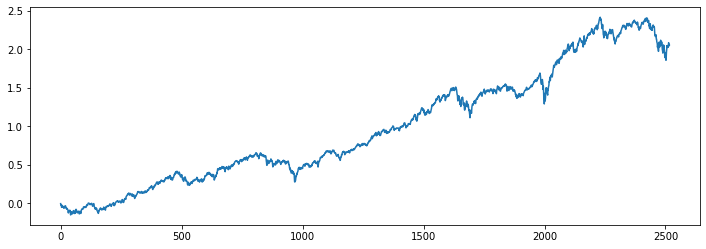

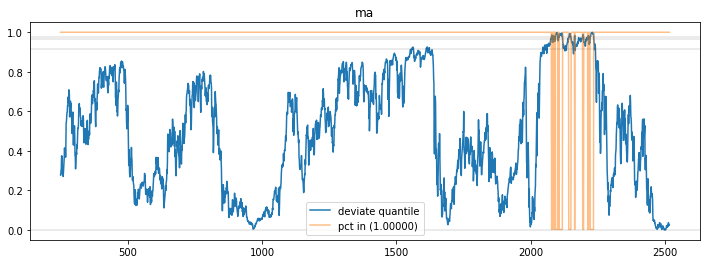

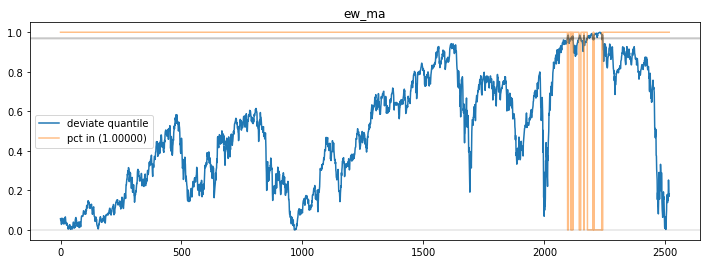

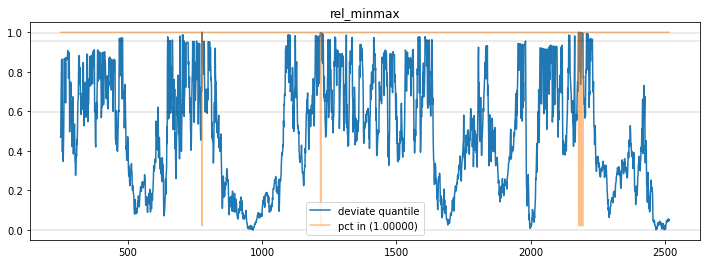

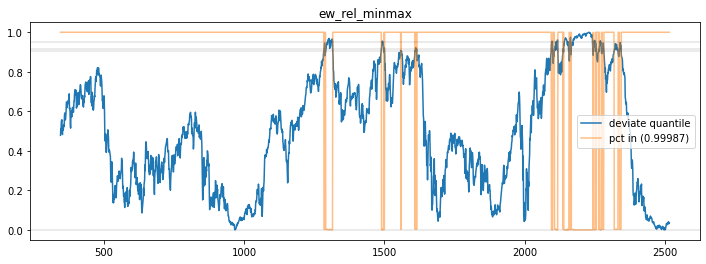

Saving mine2 params...


In [33]:
SD = 0.2213282

N_RAND = 20
N_ADJ = 180

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [34]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = best_return
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [35]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 70.51415512306227 (ew_rel_minmax)
  0.99999226 in
time param: 1668
qs:
(0.0000 - 0.9115): 1.0000
(0.9115 - 0.9397): 0.9995
(0.9397 - 0.9476): 0.9643
(0.9476 - 1.0000): 0.0033

^IXIC:
  Best Return: 81.29916856038777 (ma)
  1.00000000 in
time param: 1260
qs:
(0.0000 - 0.2500): 1.0000
(0.2500 - 0.5000): 0.9990
(0.5000 - 0.7500): 0.9980
(0.7500 - 1.0000): 0.9970

^NYA:
  Best Return: 40.33058785043541 (ew_rel_minmax)
  0.99999892 in
time param: 1375
qs:
(0.0000 - 0.8941): 1.0000
(0.8941 - 0.8991): 0.9992
(0.8991 - 0.9093): 0.0129
(0.9093 - 1.0000): 0.0002

^W5000:
  Best Return: 13.721899520385572 (ew_ma)
  1.00000000 in
time param: 837
qs:
(0.0000 - 0.9555): 1.0000
(0.9555 - 0.9625): 1.0000
(0.9625 - 0.9713): 0.0240
(0.9713 - 1.0000): 0.0000

mine1:
  Best Return: 16.7802478658944 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9204): 1.0000
(0.9204 - 0.9561): 1.0000
(0.9561 - 0.9562): 0.9999
(0.9562 - 1.0000): 0.0013

mine2:
  Best Return: 8.54611166874644

{'^GSPC': 70.51415512306227,
 '^IXIC': 81.29916856038777,
 '^NYA': 40.33058785043541,
 '^W5000': 13.721899520385572,
 'mine1': 16.7802478658944,
 'mine2': 8.546111668746443}

In [36]:
multipliers = {}
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]
    den = do_nothing_returns[stock]
    print(f'{stock}: {num} / {den}')
    multipliers[stock] = num / den
    
multipliers

^GSPC: 70.51415512306227 / 40.490424861538415
^IXIC: 81.29916856038777 / 81.29916856038777
^NYA: 40.33058785043541 / 24.558213754557055
^W5000: 13.721899520385572 / 8.222578861803155
mine1: 16.7802478658944 / 14.03912103616735
mine2: 8.546111668746443 / 5.637332371719867


{'^GSPC': 1.7415019813744457,
 '^IXIC': 1.0,
 '^NYA': 1.6422443526843074,
 '^W5000': 1.6688072867417234,
 'mine1': 1.195249177114821,
 'mine2': 1.5159850626545814}

In [37]:
mults = np.array([multipliers[key] for key in batch + ['mine1', 'mine2']])
mults[-2:] /= 2  # b/c doubling up, and half the timespan
weights = mults / mults.sum()
weights

array([0.23507854, 0.13498609, 0.22168014, 0.22526577, 0.08067101,
       0.10231845])

In [38]:
!say qp is dunzo